# 🏦 Portafoglio Combinato Contrarian: Commodities + Forex + TLT

Questo notebook combina le strategie contrarian su commodities e forex con TLT (20+ Year Treasury Bond ETF) in un portafoglio a tre asset con pesi personalizzabili, ribilanciato settimanalmente.

- **Tre asset**: Commodities contrarian, Forex contrarian, TLT (hedging)
- **Ribilanciamento settimanale** tra tutti e tre i componenti
- **Analisi completa** di performance, drawdown, correlazioni e diversificazione

---

## 📦 Setup e Importazioni

In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Importa moduli core
from core.commodity_momentum import (
    generate_long_short_commodity_momentum_signals,
    calculate_portfolio_performance
)
from core.data_loader import load_forex_data
from core.signal_generator import generate_momentum_signals
from core.backtest_engine import BacktestEngine

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
print('✅ Setup completato!')

✅ Setup completato!


## 📊 Caricamento Dati e Configurazione

- Carichiamo i dati per commodities e forex
- Impostiamo i parametri delle strategie (lookback, top_n, ecc.)

In [2]:
# --- SETUP PARAMETRI PORTAFOGLIO A TRE ASSET ---

# Imposta i pesi del portafoglio (devono sommare a 1.0)
commodities_weight = 0.1  # 10% Commodities contrarian
forex_weight = 0.6        # 60% Forex contrarian
tlt_weight = 0.3          # 30% TLT (Treasury Bonds per hedging)

# Validazione pesi
total = commodities_weight + forex_weight + tlt_weight
if abs(total - 1.0) > 0.01:
    print(f"⚠️ ATTENZIONE: La somma è {total:.2f}, deve essere 1.0!")
    raise ValueError("I pesi devono sommare a 1.0")

print(f"✅ Allocazione impostata: Commodities {commodities_weight*100:.0f}% | Forex {forex_weight*100:.0f}% | TLT {tlt_weight*100:.0f}%")

# Caricamento dati commodities
commodities_df = pd.read_parquet('../data/commodities_extended_data.parquet')
lookback_commodities = 30
commodities_top_n = 3
rebalance_weekday = 4  # venerdì

# Caricamento dati forex
forex_df = load_forex_data('../data/forex_extended_data.parquet')
lookback_forex = 30
forex_top_n = 3

print(f'✅ Dati caricati. Commodities lookback: {lookback_commodities}, top_n: {commodities_top_n}')
print(f'✅ Dati caricati. Forex lookback: {lookback_forex}, top_n: {forex_top_n}')

✅ Allocazione impostata: Commodities 10% | Forex 60% | TLT 30%
✓ Loaded forex data: 6667 days, 154 columns
✓ Date range: 2000-01-03 to 2025-08-03
✅ Dati caricati. Commodities lookback: 30, top_n: 3
✅ Dati caricati. Forex lookback: 30, top_n: 3


## 🔄 Generazione Segnali Contrarian

- Generiamo i segnali contrarian per commodities e forex separatamente, senza modificare la logica originale.

In [3]:
# Segnali contrarian commodities
signals_momentum_commodities = generate_long_short_commodity_momentum_signals(
    commodities_df, lookback_days=lookback_commodities, top_n=commodities_top_n, rebalance_weekday=rebalance_weekday
)
signals_contrarian_commodities = signals_momentum_commodities * -1

# Segnali contrarian forex
signals_momentum_forex = generate_momentum_signals(
    price_data=forex_df,
    lookback_days=lookback_forex,
    top_n=forex_top_n,
    rebalance_freq='weekly'
)
signals_contrarian_forex = signals_momentum_forex * -1

print('✅ Segnali contrarian generati per commodities e forex!')

✓ Generated momentum signals: 30d lookback, 3 long + 3 short
✓ Rebalancing: weekly
✓ Signal range: 2000-01-03 to 2025-08-03
✅ Segnali contrarian generati per commodities e forex!


## 🚀 Backtest Strategie Contrarian Separate

- Eseguiamo il backtest delle strategie contrarian commodities e forex separatamente, mantenendo la logica originale.

In [4]:
# Backtest commodities contrarian
contrarian_equity_commodities = calculate_portfolio_performance(signals_contrarian_commodities, commodities_df)
contrarian_returns_commodities = contrarian_equity_commodities.pct_change().fillna(0)

# Backtest forex contrarian
engine_contrarian_forex = BacktestEngine(initial_capital=100000, leverage=1.0)
results_contrarian_forex = engine_contrarian_forex.run_backtest(forex_df, signals_contrarian_forex, verbose=False)
contrarian_equity_forex = engine_contrarian_forex.portfolio_value
contrarian_returns_forex = engine_contrarian_forex.portfolio_returns

print('✅ Backtest completato per entrambe le strategie!')

INFO:core.backtest_engine:BacktestEngine initialized with 100,000 starting capital
INFO:core.backtest_engine:Detected 22 currency pairs
INFO:core.backtest_engine:Price data range: 2000-01-03 00:00:00+00:00 to 2025-08-03 00:00:00+01:00
INFO:core.backtest_engine:Signals data range: 2000-01-03 00:00:00+00:00 to 2025-08-03 00:00:00+01:00
INFO:core.backtest_engine:Calculating daily returns...
INFO:core.backtest_engine:Calculated returns for 22 pairs
INFO:core.backtest_engine:Calculating performance metrics...


✅ Backtest completato per entrambe le strategie!


## 📈 Caricamento Dati TLT per Hedging

- Scarichiamo i dati TLT (20+ Year Treasury Bond ETF) da Yahoo Finance
- Normalizziamo per allinearlo alle altre equity curve

In [5]:
# Caricamento dati TLT
import yfinance as yf

# Determiniamo il range di date dai backtest esistenti
commodities_start = contrarian_equity_commodities.index[0]
commodities_end = contrarian_equity_commodities.index[-1]
forex_start = contrarian_equity_forex.index[0] 
forex_end = contrarian_equity_forex.index[-1]

# Prendiamo il range più ampio per TLT
tlt_start = min(commodities_start, forex_start)
tlt_end = max(commodities_end, forex_end)

print(f"Scaricando TLT dal {tlt_start.strftime('%Y-%m-%d')} al {tlt_end.strftime('%Y-%m-%d')}")

# Scarica dati TLT
tlt_data = yf.download('TLT', start=tlt_start, end=tlt_end, progress=False)

if tlt_data.empty:
    raise ValueError("❌ ERRORE: Nessun dato TLT scaricato!")

# Usa Adj Close se disponibile, altrimenti Close
if 'Adj Close' in tlt_data.columns:
    tlt_prices = tlt_data['Adj Close']
elif 'Close' in tlt_data.columns:
    tlt_prices = tlt_data['Close']
else:
    raise ValueError("❌ ERRORE: Colonne Close o Adj Close non trovate in TLT")

# Rimuovi timezone se presente per allineamento
if tlt_prices.index.tz:
    tlt_prices.index = tlt_prices.index.tz_localize(None)

print(f"✅ TLT scaricato: {len(tlt_prices)} giorni dal {tlt_prices.index[0]} al {tlt_prices.index[-1]}")

# Calcoliamo l'equity curve TLT (normalizzata a partire da 1)
tlt_equity = tlt_prices / tlt_prices.iloc[0]
tlt_returns = tlt_equity.pct_change().fillna(0)

print(f"✅ TLT equity curve creata, range: {float(tlt_equity.iloc[0]):.2f} → {float(tlt_equity.iloc[-1]):.2f}")

Scaricando TLT dal 2000-01-03 al 2025-08-04
✅ TLT scaricato: 5790 giorni dal 2002-07-30 00:00:00 al 2025-08-01 00:00:00
✅ TLT equity curve creata, range: 1.00 → 2.35


## 🏦 Combinazione Portafoglio a Tre Asset (Commodities + Forex + TLT)

- Allineiamo le date delle tre equity curve (commodities, forex, TLT)
- Combiniamo le tre strategie secondo i pesi impostati, ribilanciato settimanalmente

In [6]:
# Rimuovi i fusi orari dagli indici per allineare le date
commodities_idx = contrarian_equity_commodities.index.tz_localize(None) if contrarian_equity_commodities.index.tz else contrarian_equity_commodities.index
forex_idx = contrarian_equity_forex.index.tz_localize(None) if contrarian_equity_forex.index.tz else contrarian_equity_forex.index
tlt_idx = tlt_equity.index.tz_localize(None) if tlt_equity.index.tz else tlt_equity.index

commodities_eq = pd.Series(contrarian_equity_commodities.values, index=commodities_idx)
forex_eq = pd.Series(contrarian_equity_forex.values, index=forex_idx)

# Fix per TLT: usa direttamente la Series o flatten se necessario
if isinstance(tlt_equity, pd.Series):
    tlt_eq = tlt_equity.copy()
    tlt_eq.index = tlt_idx
else:
    # Se è un DataFrame, prendi la prima colonna e flatten
    tlt_values = tlt_equity.values.flatten() if tlt_equity.values.ndim > 1 else tlt_equity.values
    tlt_eq = pd.Series(tlt_values, index=tlt_idx)

# Trova il periodo comune tra tutti e tre gli asset
start_date = max(commodities_eq.index[0], forex_eq.index[0], tlt_eq.index[0])
end_date = min(commodities_eq.index[-1], forex_eq.index[-1], tlt_eq.index[-1])

print(f"Periodo combinato: {start_date} → {end_date}")

# Filtra per il periodo comune
commodities_eq = commodities_eq.loc[start_date:end_date]
forex_eq = forex_eq.loc[start_date:end_date]
tlt_eq = tlt_eq.loc[start_date:end_date]

print(f"Commodities eq: {commodities_eq.index[0]} → {commodities_eq.index[-1]}, len={len(commodities_eq)}")
print(f"Forex eq: {forex_eq.index[0]} → {forex_eq.index[-1]}, len={len(forex_eq)}")
print(f"TLT eq: {tlt_eq.index[0]} → {tlt_eq.index[-1]}, len={len(tlt_eq)}")

# Allinea le date (intersection di tutti e tre)
common_dates = commodities_eq.index.intersection(forex_eq.index).intersection(tlt_eq.index)
print(f"Date comuni trovate: {len(common_dates)}")
print(f"Prime 5 date comuni: {list(common_dates[:5])}")

commodities_eq = commodities_eq.loc[common_dates]
forex_eq = forex_eq.loc[common_dates]
tlt_eq = tlt_eq.loc[common_dates]

if len(common_dates) < 2:
    print("❌ ERRORE: Non ci sono abbastanza date comuni tra le tre equity curve!")
    raise ValueError("Non ci sono abbastanza date comuni per combinare le strategie.")

# Normalizza tutte le equity curve a 1 all'inizio
commodities_eq_norm = commodities_eq / commodities_eq.iloc[0]
forex_eq_norm = forex_eq / forex_eq.iloc[0]
tlt_eq_norm = tlt_eq / tlt_eq.iloc[0]

# CRITICAL FIX: Implementa rebalancing settimanale corretto per tutti e tre gli asset
print("🔧 Implementando rebalancing settimanale sincronizzato per tutti e tre gli asset...")

# Trova tutti i venerdì nel periodo comune
rebalance_dates = common_dates[common_dates.weekday == 4]  # Venerdì
print(f"Date di rebalancing trovate: {len(rebalance_dates)}")

# Crea portafoglio con rebalancing settimanale sincronizzato
portfolio_values = []
current_weights = None

for i, date in enumerate(common_dates):
    if date in rebalance_dates:
        # Ribilanciamento: aggiorna i pesi
        current_weights = {
            'commodities': commodities_weight,
            'forex': forex_weight, 
            'tlt': tlt_weight
        }
        if i == 0:
            print(f"Primo rebalancing: {date.strftime('%Y-%m-%d')} (venerdì)")
        
    if current_weights is None:
        # Prima data disponibile, usa pesi di default
        current_weights = {
            'commodities': commodities_weight,
            'forex': forex_weight,
            'tlt': tlt_weight
        }
    
    # Calcola valore portafoglio con pesi fissi fino al prossimo rebalancing
    portfolio_value = (
        commodities_eq_norm.loc[date] * current_weights['commodities'] +
        forex_eq_norm.loc[date] * current_weights['forex'] +
        tlt_eq_norm.loc[date] * current_weights['tlt']
    )
    portfolio_values.append(portfolio_value)

portfolio_eq = pd.Series(portfolio_values, index=common_dates)
portfolio_returns = portfolio_eq.pct_change().fillna(0)

print(f'✅ Portafoglio combinato creato con REBALANCING SETTIMANALE SINCRONIZZATO!')
print(f'✅ Pesi fissi tra rebalancing: Commodities {commodities_weight*100:.0f}%, Forex {forex_weight*100:.0f}%, TLT {tlt_weight*100:.0f}%')
print(f'✅ Rebalancing ogni venerdì, {len(rebalance_dates)} ribilanciamenti totali')

Periodo combinato: 2006-05-17 00:00:00 → 2025-08-01 00:00:00
Commodities eq: 2006-05-17 00:00:00 → 2025-08-01 00:00:00, len=4840
Forex eq: 2006-05-17 00:00:00 → 2025-08-01 00:00:00, len=5006
TLT eq: 2006-05-17 00:00:00 → 2025-08-01 00:00:00, len=4833
Date comuni trovate: 4826
Prime 5 date comuni: [Timestamp('2006-05-17 00:00:00'), Timestamp('2006-05-18 00:00:00'), Timestamp('2006-05-19 00:00:00'), Timestamp('2006-05-22 00:00:00'), Timestamp('2006-05-23 00:00:00')]
🔧 Implementando rebalancing settimanale sincronizzato per tutti e tre gli asset...
Date di rebalancing trovate: 969
✅ Portafoglio combinato creato con REBALANCING SETTIMANALE SINCRONIZZATO!
✅ Pesi fissi tra rebalancing: Commodities 10%, Forex 60%, TLT 30%
✅ Rebalancing ogni venerdì, 969 ribilanciamenti totali


## 📈 Visualizzazione Equity Curve e Performance

- Visualizziamo le equity curve delle singole strategie e del portafoglio combinato
- Calcoliamo e mostriamo le principali metriche di performance

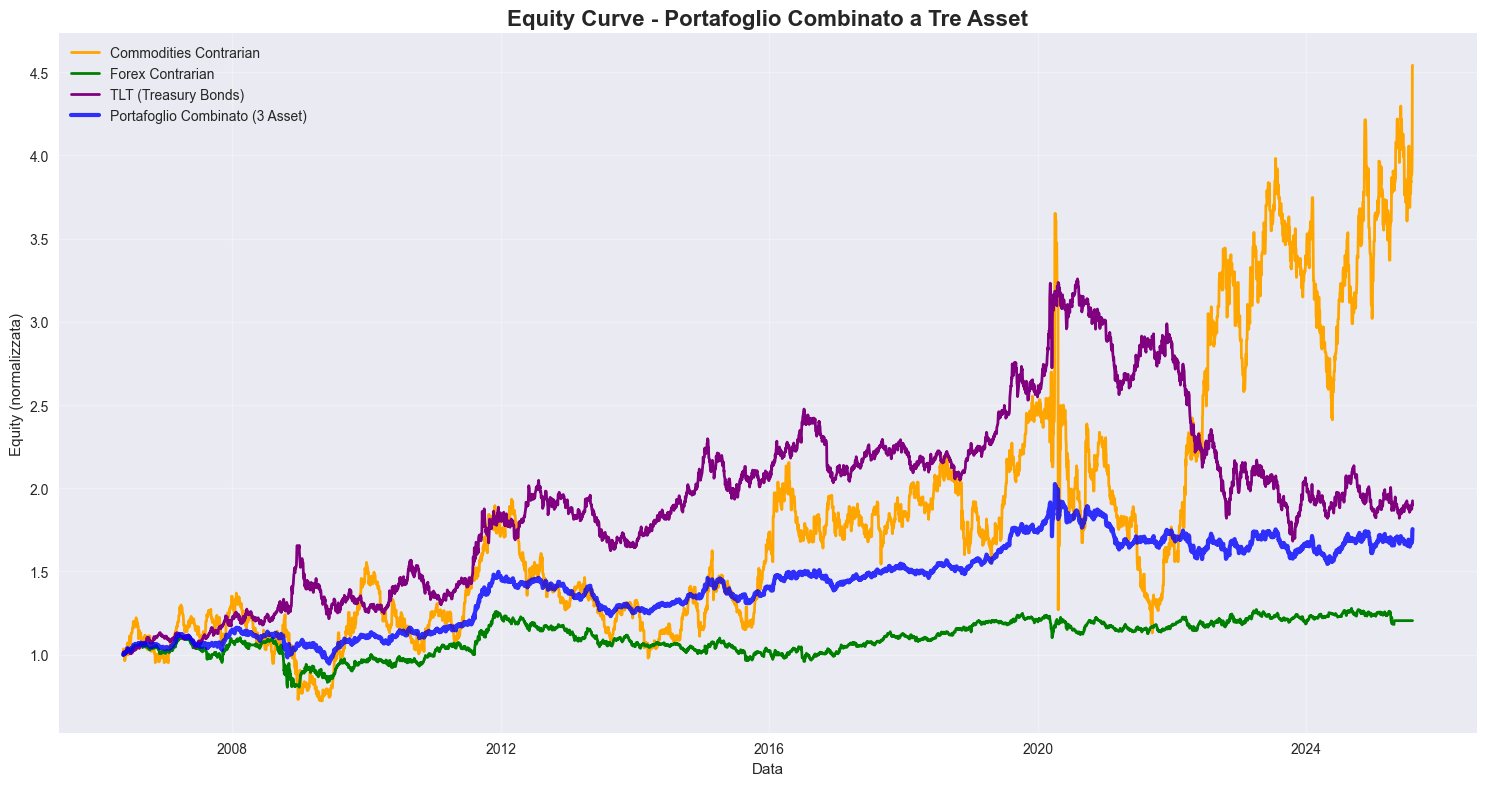

📊 PERFORMANCE PORTAFOGLIO A TRE ASSET
METRICA            COMBINATO  COMMODITIES        FOREX          TLT
--------------------------------------------------------------------------------
Totale (%)             75.43       354.09        20.47        92.47
Annuale (%)             2.98         8.22         0.98         3.48
Volatilità (%)          9.13        35.63        10.43        15.11
Sharpe                  0.37         0.42         0.15         0.30
Max DD (%)            -23.69       -69.03       -27.46       -48.35


In [7]:
plt.figure(figsize=(15, 8))
plt.plot(commodities_eq_norm.index, commodities_eq_norm.values, label='Commodities Contrarian', color='orange', linewidth=2)
plt.plot(forex_eq_norm.index, forex_eq_norm.values, label='Forex Contrarian', color='green', linewidth=2)
plt.plot(tlt_eq_norm.index, tlt_eq_norm.values, label='TLT (Treasury Bonds)', color='purple', linewidth=2)
plt.plot(portfolio_eq.index, portfolio_eq.values, label='Portafoglio Combinato (3 Asset)', color='blue', linewidth=3, alpha=0.8)
plt.title('Equity Curve - Portafoglio Combinato a Tre Asset', fontsize=16, fontweight='bold')
plt.ylabel('Equity (normalizzata)')
plt.xlabel('Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calcolo metriche per tutti e quattro gli asset/portfolio
from collections import OrderedDict

def perf_stats(equity, returns):
    stats = OrderedDict()
    stats['Totale (%)'] = (equity.iloc[-1] - 1) * 100
    stats['Annuale (%)'] = ((equity.iloc[-1] ** (252 / len(equity))) - 1) * 100
    stats['Volatilità (%)'] = returns.std() * np.sqrt(252) * 100
    stats['Sharpe'] = (returns.mean() * 252) / (returns.std() * np.sqrt(252))
    running_max = equity.cummax()
    drawdown = (equity / running_max) - 1
    stats['Max DD (%)'] = drawdown.min() * 100
    return stats

stats_combined = perf_stats(portfolio_eq, portfolio_returns)
stats_commodities = perf_stats(commodities_eq_norm, commodities_eq_norm.pct_change().fillna(0))
stats_forex = perf_stats(forex_eq_norm, forex_eq_norm.pct_change().fillna(0))
stats_tlt = perf_stats(tlt_eq_norm, tlt_eq_norm.pct_change().fillna(0))

print('📊 PERFORMANCE PORTAFOGLIO A TRE ASSET')
print('='*80)
print(f"{'METRICA':<15} {'COMBINATO':>12} {'COMMODITIES':>12} {'FOREX':>12} {'TLT':>12}")
print('-'*80)
for k in stats_combined.keys():
    print(f"{k:<15} {stats_combined[k]:>12.2f} {stats_commodities[k]:>12.2f} {stats_forex[k]:>12.2f} {stats_tlt[k]:>12.2f}")
print('='*80)

## 📉 Analisi Drawdown e Rolling Metrics

- Analizziamo il drawdown del portafoglio combinato
- Visualizziamo rolling returns, volatilità e Sharpe ratio

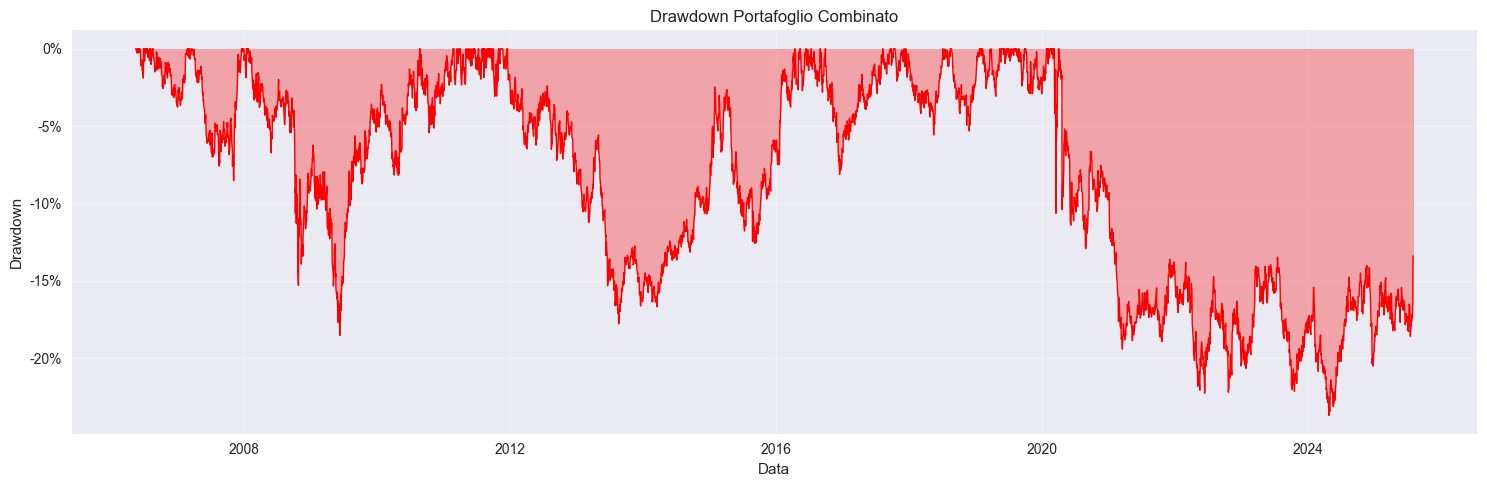

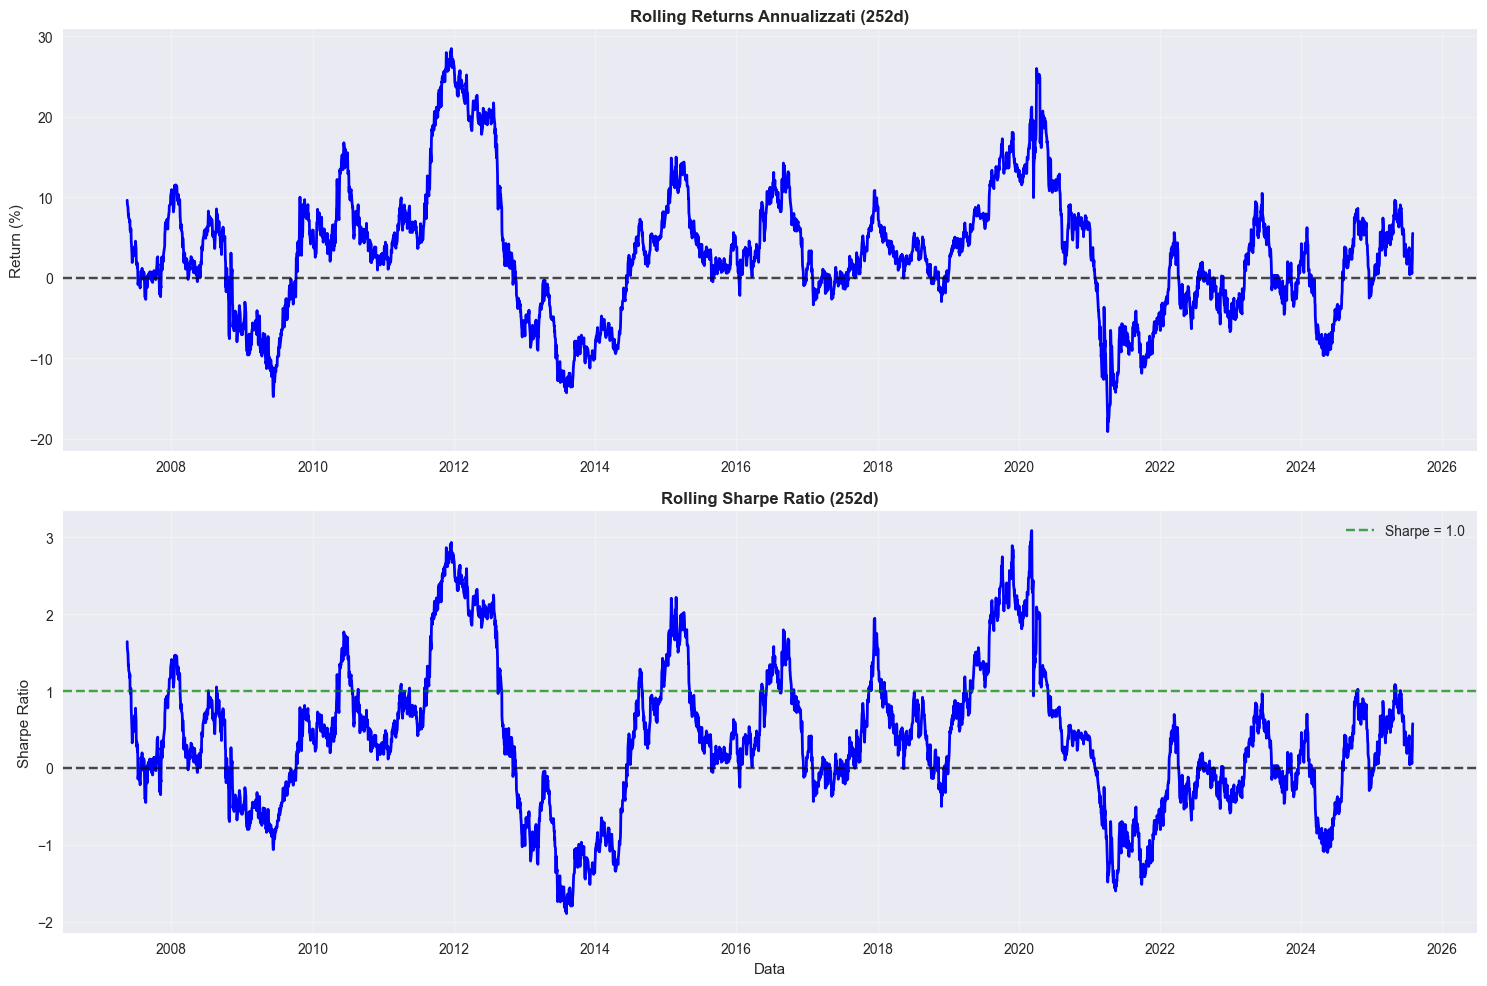

Top 5 Drawdown peggiori:
2024-04-25: -23.69%
2024-04-30: -23.45%
2024-04-26: -23.39%
2024-04-29: -23.29%
2024-05-01: -23.26%


In [8]:
# Drawdown
running_max = portfolio_eq.cummax()
drawdown = (portfolio_eq / running_max) - 1
plt.figure(figsize=(15, 5))
plt.fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red')
plt.plot(drawdown.index, drawdown.values, color='red', linewidth=1)
plt.title('Drawdown Portafoglio Combinato')
plt.xlabel('Data')
plt.ylabel('Drawdown')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Rolling metrics
window = 252  # 1 anno
rolling_ret = portfolio_returns.rolling(window).mean() * 252 * 100
rolling_vol = portfolio_returns.rolling(window).std() * np.sqrt(252) * 100
rolling_sharpe = rolling_ret / rolling_vol

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(rolling_ret.index, rolling_ret.values, color='blue', linewidth=2)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax1.set_title('Rolling Returns Annualizzati (252d)', fontweight='bold')
ax1.set_ylabel('Return (%)')
ax1.grid(True, alpha=0.3)

ax2.plot(rolling_sharpe.index, rolling_sharpe.values, color='blue', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax2.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Sharpe = 1.0')
ax2.set_title('Rolling Sharpe Ratio (252d)', fontweight='bold')
ax2.set_ylabel('Sharpe Ratio')
ax2.set_xlabel('Data')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('Top 5 Drawdown peggiori:')
worst_drawdowns = drawdown.nsmallest(5)
for date, dd in worst_drawdowns.items():
    print(f'{date.strftime('%Y-%m-%d')}: {dd:.2%}')

## 📈 Visualizzazione Equity Curve su Scala Logaritmica

- Visualizziamo la curva del portafoglio combinato su scala logaritmica per evidenziare la crescita esponenziale e i drawdown.

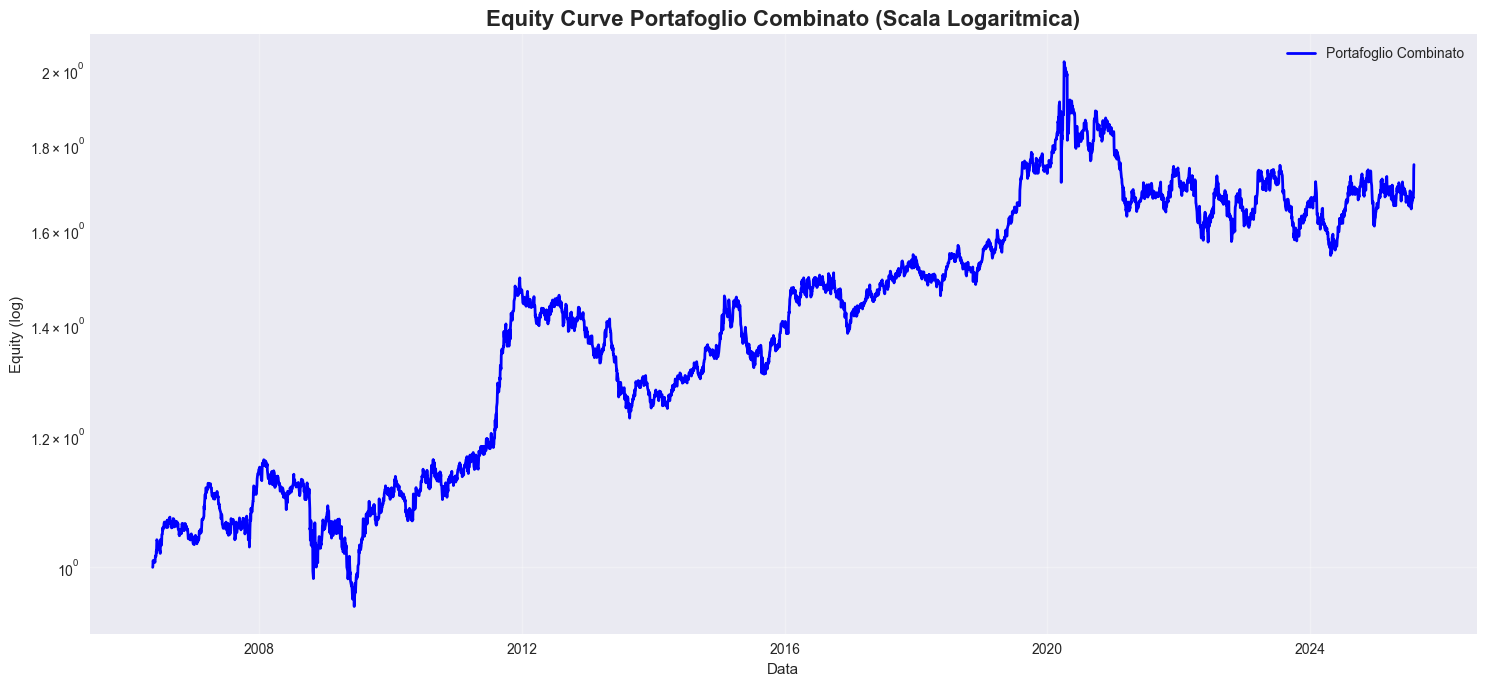

In [9]:
plt.figure(figsize=(15, 7))
plt.plot(portfolio_eq.index, portfolio_eq.values, color='blue', linewidth=2, label='Portafoglio Combinato')
plt.yscale('log')
plt.title('Equity Curve Portafoglio Combinato (Scala Logaritmica)', fontsize=16, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Equity (log)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 🔗 Rolling Correlazioni tra i Tre Asset

- Calcoliamo e visualizziamo le rolling correlation (finestra 90 giorni) tra tutti e tre gli asset
- Commodities vs Forex, Commodities vs TLT, Forex vs TLT

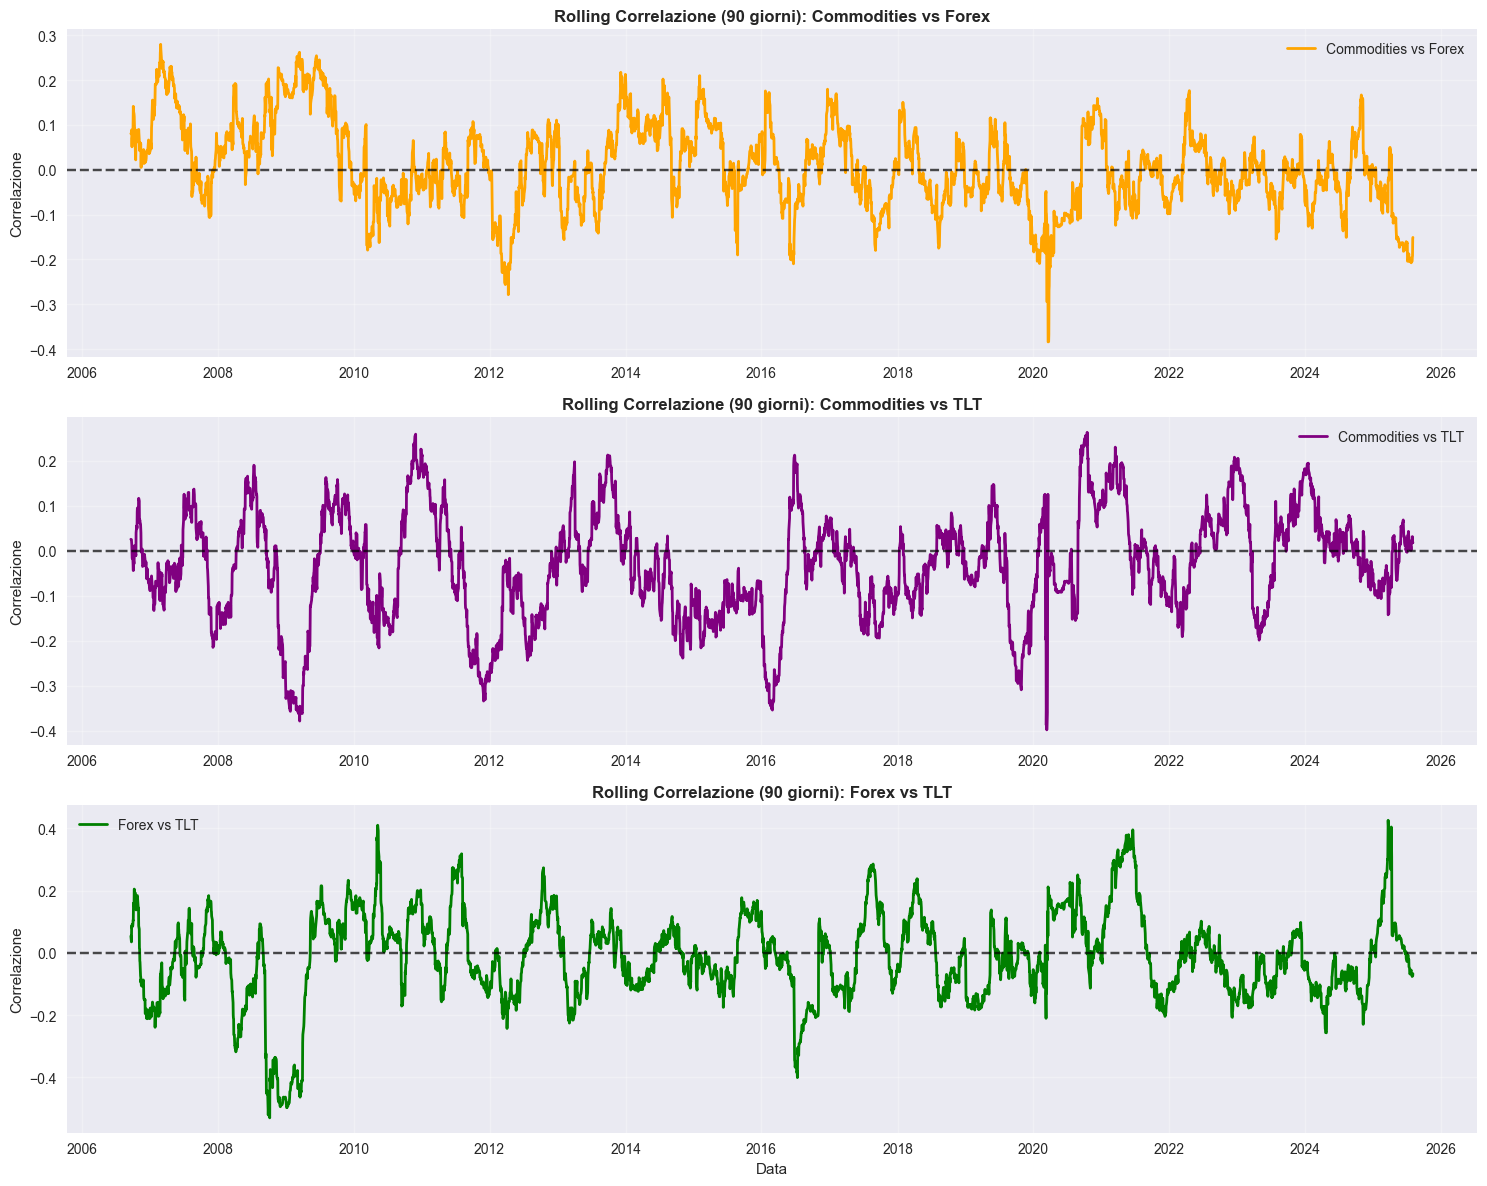

📊 STATISTICHE CORRELAZIONI (periodo completo)
Commodities vs Forex - Media: 0.007, Std: 0.096
Commodities vs TLT   - Media: -0.035, Std: 0.121
Forex vs TLT         - Media: -0.014, Std: 0.144
📊 CORRELAZIONI ULTIME 252 SESSIONI (circa 1 anno)
Commodities vs Forex: -0.057
Commodities vs TLT:   -0.023
Forex vs TLT:         0.017


In [10]:
window = 90  # 90 giorni

# Calcoliamo i rendimenti giornalieri per tutti e tre gli asset
commodities_returns = commodities_eq_norm.pct_change().fillna(0)
forex_returns = forex_eq_norm.pct_change().fillna(0)
tlt_returns = tlt_eq_norm.pct_change().fillna(0)

# Rolling correlations tra tutte le coppie
rolling_corr_com_fx = commodities_returns.rolling(window).corr(forex_returns)
rolling_corr_com_tlt = commodities_returns.rolling(window).corr(tlt_returns)
rolling_corr_fx_tlt = forex_returns.rolling(window).corr(tlt_returns)

# Plot delle tre correlazioni
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Commodities vs Forex
ax1.plot(rolling_corr_com_fx.index, rolling_corr_com_fx.values, color='orange', linewidth=2, label='Commodities vs Forex')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax1.set_title('Rolling Correlazione (90 giorni): Commodities vs Forex', fontweight='bold')
ax1.set_ylabel('Correlazione')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Commodities vs TLT
ax2.plot(rolling_corr_com_tlt.index, rolling_corr_com_tlt.values, color='purple', linewidth=2, label='Commodities vs TLT')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax2.set_title('Rolling Correlazione (90 giorni): Commodities vs TLT', fontweight='bold')
ax2.set_ylabel('Correlazione')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Forex vs TLT
ax3.plot(rolling_corr_fx_tlt.index, rolling_corr_fx_tlt.values, color='green', linewidth=2, label='Forex vs TLT')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax3.set_title('Rolling Correlazione (90 giorni): Forex vs TLT', fontweight='bold')
ax3.set_ylabel('Correlazione')
ax3.set_xlabel('Data')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

# Statistiche di correlazione
print('📊 STATISTICHE CORRELAZIONI (periodo completo)')
print('='*60)
print(f'Commodities vs Forex - Media: {rolling_corr_com_fx.mean():.3f}, Std: {rolling_corr_com_fx.std():.3f}')
print(f'Commodities vs TLT   - Media: {rolling_corr_com_tlt.mean():.3f}, Std: {rolling_corr_com_tlt.std():.3f}') 
print(f'Forex vs TLT         - Media: {rolling_corr_fx_tlt.mean():.3f}, Std: {rolling_corr_fx_tlt.std():.3f}')
print('='*60)

# Correlazione istantanea (ultimo anno)
recent_period = 252  # ultimo anno
if len(commodities_returns) >= recent_period:
    recent_corr_com_fx = commodities_returns.iloc[-recent_period:].corr(forex_returns.iloc[-recent_period:])
    recent_corr_com_tlt = commodities_returns.iloc[-recent_period:].corr(tlt_returns.iloc[-recent_period:])
    recent_corr_fx_tlt = forex_returns.iloc[-recent_period:].corr(tlt_returns.iloc[-recent_period:])
    
    print('📊 CORRELAZIONI ULTIME 252 SESSIONI (circa 1 anno)')
    print('='*60)
    print(f'Commodities vs Forex: {recent_corr_com_fx:.3f}')
    print(f'Commodities vs TLT:   {recent_corr_com_tlt:.3f}')
    print(f'Forex vs TLT:         {recent_corr_fx_tlt:.3f}')
    print('='*60)